### Imports

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import re

listings = pd.read_csv('./Airbnb Seattle Listings/listings.csv',dtype={'zipcode':object, 'review_scores_location':float})
prop_assessments = pd.read_csv('./Airbnb Seattle Listings/house_price.csv', dtype={'zipcode':object})
house_rents = pd.read_csv('./Airbnb Seattle Listings/rent.csv', encoding='latin-1', dtype={'id':object,'State_Code':object,'State_Name':object,'State_ab':object,'County':object,'City':object,'Place':object,'Type':object,'Primary':object,'Zip_Code':object,'Area_Code':object,'ALand':object,'AWater':object,'Lat':object, 'Lon':object, 'Mean':int, 'Median':int, 'Stdev':int,'Samples':int})

# Used for understanding relationships between data attributes, but not used in final sanitized and labeled data
#reviews = pd.read_csv('./Airbnb Seattle Listings/reviews.csv',dtype={'zipcode':object})
calendar = pd.read_csv('./Airbnb Seattle Listings/calendar.csv',dtype={'zipcode':object})


### Homogenize attributes

In [27]:
# Price string to float
listings.monthly_price = listings.monthly_price.replace('[\$,]', '', regex=True).astype(float)
listings.weekly_price = listings.weekly_price.replace('[\$,]', '', regex=True).astype(float)
listings.price = listings.price.replace('[\$,]', '', regex=True).astype(float)
listings.security_deposit = listings.security_deposit.replace('[\$,]', '', regex=True).astype(float)
listings.cleaning_fee = listings.cleaning_fee.replace('[\$,]', '', regex=True).astype(float)

# remove entries with corrupt zipcode
listings = listings[listings.zipcode != "99\n98122"]

# rename attribute to match other dataframes
listings = listings.rename(columns={'id': 'listing_id'})
house_rents = house_rents.rename(columns={'Zip_Code': 'zipcode'})

# index dataframes by listing_id
#listings = listings.set_index('listing_id')
#calendar = calendar.set_index('listing_id')
#reviews = reviews.set_index('listing_id')

### Preview Data

In [28]:
listings.head()

,listing_id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [29]:
house_rents.head()

,id,State_Code,State_Name,State_ab,County,City,Place,Type,Primary,zipcode,Area_Code,ALand,AWater,Lat,Lon,Mean,Median,Stdev,Samples
0,0101901,01,Alabama,AL,Chambers County,Wadley,Abanda,CDP,place,36276,256,7764034,34284,33.091627,-85.527029,972,968,51,12
1,0101904,01,Alabama,AL,Winston County,Addison,Addison,Town,place,35540,256,9753292,83417,34.202681,-87.178004,519,460,275,64
2,0101907,01,Alabama,AL,Marshall County,Albertville,Albertville city,City,place,35950,256,68731806,258708,34.26313,-86.21066,625,585,234,2560
3,0101910,01,Alabama,AL,Pickens County,Aliceville,Aliceville city,City,place,35442,205,11819855,0,33.123686,-88.159364,546,438,354,574
4,0101913,01,Alabama,AL,Etowah County,Walnut Grove,Altoona,Town,place,35990,205,11193369,25442,34.039204,-86.305697,350,303,185,114


In [30]:
prop_assessments.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Create dataframe with useful data

The __square_feet__ attribute could help derive the relationship between cost of the AirBnB and the actual cost of the house based, for example taking into account the added value given by its surroundings.

Unfortunately it is vastly NaN's, we will not use it in our sanitized data

In [31]:
total_sq_ft = len(listings.square_feet)
nan_sq_ft = total_sq_ft - listings.square_feet.count()
print('Total square_feet entries: {}, Total square_feet NaN: {}'.format(total_sq_ft, nan_sq_ft))

Total square_feet entries: 3817, Total square_feet NaN: 3720


__TODO:__ Not sure if this is supposed to be after you created the data variable in the next section?

We attempted to further sanitize the __price_x__ by dropping out outlier points either through mean of stdev.

Unfortunately, it proved to have negligable effect on the score of the trained model

In [32]:
#data = data.join(data.groupby('zipcode')['price_x'].mean(), on='zipcode', rsuffix='_average_per_zip')
#data = data.drop(data.index[np.abs(data.price_x - data.price_x_average_per_zip) > 0.5 * data.price_x_average_per_zip])
# OR
#data = data.join(data.groupby('zipcode')['price_x'].std(), on='zipcode', rsuffix='_std_per_zip')
#data = data.drop(data.index[np.abs(data.price_x - data.price_x_std_per_zip) > 3 * data.price_x_std_per_zip])

Build a clean dataframe from the relevant attributes of other dataframes:

In [73]:
data = listings[['price', 'review_scores_location', 'monthly_price', 'weekly_price', 'square_feet', 'property_type', 'bedrooms','bathrooms','accommodates', 'zipcode', 'host_neighbourhood', 'review_scores_rating', 'bed_type', 'beds', 'number_of_reviews', 'longitude', 'latitude', 'security_deposit', 'cleaning_fee', 'guests_included', 'availability_365', 'transit', 'reviews_per_month','host_listings_count']]

def nan_to_zero(x):
    if np.isnan(x): return 0
    return x

def parse_bed_type(bed_type):
    if bed_type == 'Real Bed': return 0
    elif bed_type == 'Futon': return 3
    elif bed_type == 'Pull-out Sofa': return 4
    elif bed_type == 'Couch': return 9
    elif bed_type == 'Airbed': return 6
    else: return 1

data['bed_type'] = data.bed_type.apply(parse_bed_type)
data.security_deposit = data.security_deposit.apply(nan_to_zero)
data.cleaning_fee = data.cleaning_fee.apply(nan_to_zero)
data.reviews_per_month = data.cleaning_fee.apply(nan_to_zero)

# Turn Transit into a number
transformed_transit = data.transit
busCount=np.array([0]*len(data.index))
parkingCount=np.array([0]*len(data.index))
taxiCount=np.array([0]*len(data.index))
walkCount=np.array([0]*len(data.index))
bikeCount=np.array([0]*len(data.index))
emptyCount=np.array([0]*len(data.index))

i = 0

for entry in transformed_transit:
    if (isinstance(entry, float)):
        emptyCount[i]+=1
        i+=1
        continue
    busCount[i] = len(re.findall(r'bus', entry, re.IGNORECASE))
    parkingCount[i] = len(re.findall(r'parking', entry, re.IGNORECASE))
    taxiCount[i] = len(re.findall(r'uber|taxi|lyft|car2go', entry, re.IGNORECASE))
    walkCount[i] = len(re.findall(r'walk', entry, re.IGNORECASE))
    bikeCount[i] = len(re.findall(r'bike|biking', entry, re.IGNORECASE))
    i+=1
    
transit_types = ['bus', 'parking', 'taxi', 'walk', 'bike', 'no_transit']
data['bus'] = busCount
data['parking'] = parkingCount
data['taxi'] = taxiCount
data['walk'] = walkCount
data['bike'] = bikeCount
data['no_transit'] = emptyCount

data = pd.merge(data, prop_assessments[['zipcode','bedrooms', 'bathrooms', 'price']], how='inner', on=['zipcode','bedrooms','bathrooms'])
data.rename(columns= {'price_x':'daily_price_airbnb', 'monthly_price':'monthly_price_airbnb', 'weekly_price':'weekly_price_airbnb', 'price_y':'housing_price'}, inplace=True)
# average house price by bathrooms, bedrooms, zipcode
data = data.join(data.groupby(['zipcode','bedrooms', 'bathrooms']).housing_price.mean(), on=['zipcode','bedrooms', 'bathrooms'], rsuffix='_avg')

print('\nSanitized Data:')
data.head()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand


Sanitized Data:


,daily_price_airbnb,review_scores_location,monthly_price_airbnb,weekly_price_airbnb,square_feet,property_type,bedrooms,bathrooms,accommodates,zipcode,...,reviews_per_month,host_listings_count,bus,parking,taxi,walk,bike,no_transit,housing_price,housing_price_avg
0,450.0,9.0,NaN,NaN,NaN,House,3,2.0,6,98119,...,125.0,2.0,2,2,0,0,0,0,716000.0,758533.0
1,450.0,9.0,NaN,NaN,NaN,House,3,2.0,6,98119,...,125.0,2.0,2,2,0,0,0,0,750000.0,758533.0
2,450.0,9.0,NaN,NaN,NaN,House,3,2.0,6,98119,...,125.0,2.0,2,2,0,0,0,0,808250.0,758533.0
3,450.0,9.0,NaN,NaN,NaN,House,3,2.0,6,98119,...,125.0,2.0,2,2,0,0,0,0,840500.0,758533.0
4,450.0,9.0,NaN,NaN,NaN,House,3,2.0,6,98119,...,125.0,2.0,2,2,0,0,0,0,677915.0,758533.0


### Group by neighbourhood

In [63]:

by_neighbourhood = data.groupby(['host_neighbourhood'])

neighbourhoods = data.host_neighbourhood.dropna().unique()

airbnb_daily_rent_by_neighbourhood = by_neighbourhood.daily_price_airbnb.mean()

airbnb_location_review_scores = by_neighbourhood.review_scores_location.mean()


airbnb_by_neighbourhood = pd.concat([airbnb_daily_rent_by_neighbourhood, airbnb_location_review_scores], axis=1)

airbnb_by_neighbourhood.head()

,daily_price_airbnb,review_scores_location
host_neighbourhood,,
Alki,198.768953,9.739130
Anaheim,219.000000,NaN
Arbor Heights,200.000000,9.000000
Atlantic,136.769752,8.893939
Ballard,142.987259,9.777309


### Grouping by Zipcode

In [64]:
by_zip = data.groupby(['zipcode'])

zips = data.zipcode.dropna().unique()

daily_price_airbnb_by_zipcode = by_zip.daily_price_airbnb.mean()
airbnb_review_scores_by_zipcode = by_zip.review_scores_location.mean()
airbnb_by_zip = pd.concat([daily_price_airbnb_by_zipcode, airbnb_review_scores_by_zipcode], axis=1)
print(str(len(airbnb_by_zip.index)))


# daily_price_airbnb_by_zipcode.head()
airbnb_by_zip.head()

23


,daily_price_airbnb,review_scores_location
zipcode,,
98102,205.810811,9.541353
98103,151.741795,9.711560
98105,170.037931,9.523013
98106,99.722287,8.945910
98107,181.766329,9.752723



### Plot Both Groupings

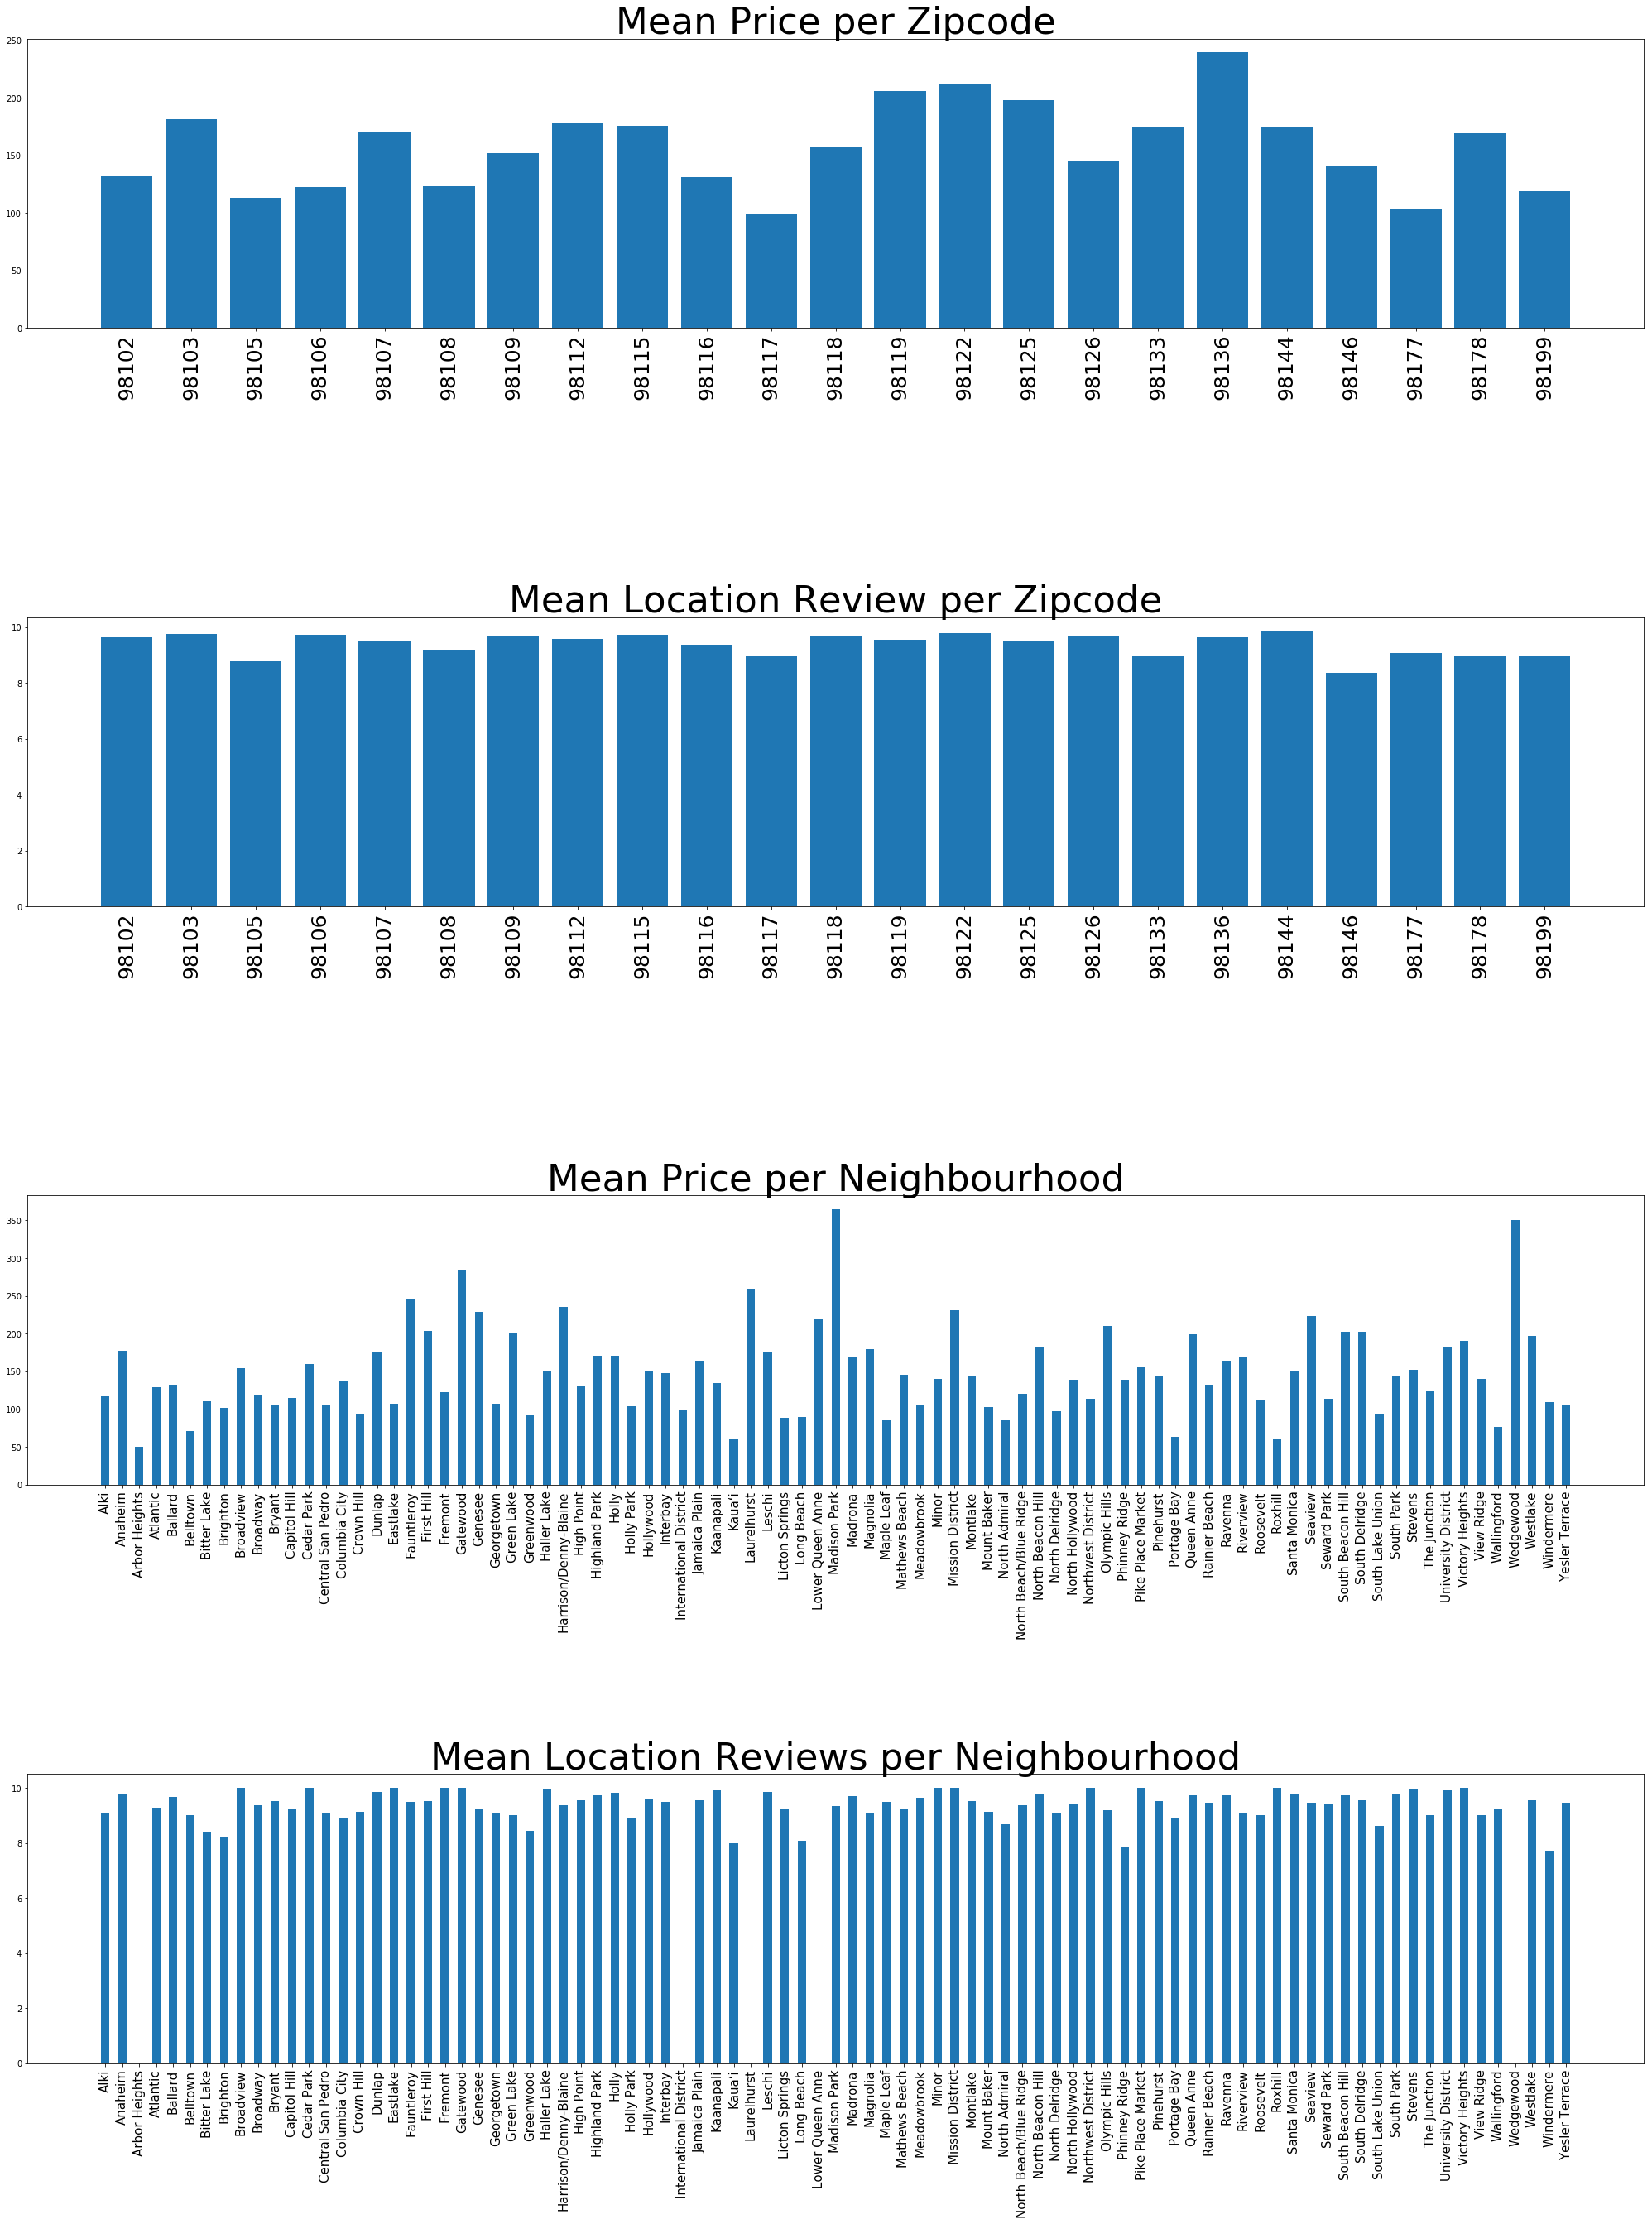

In [65]:
fig, xarr = plt.subplots(4,1, figsize=(35,45))
fig.subplots_adjust(hspace=1)
  
xarr[0].bar(zips, daily_price_airbnb_by_zipcode)
xarr[0].set_title('Mean Price per Zipcode')

xarr[1].bar(zips, airbnb_review_scores_by_zipcode)
xarr[1].set_title('Mean Location Review per Zipcode')

xarr[2].bar(neighbourhoods, airbnb_daily_rent_by_neighbourhood, width=0.5)
xarr[2].set_title('Mean Price per Neighbourhood');

xarr[3].bar(neighbourhoods, airbnb_location_review_scores, width=0.5)
xarr[3].set_title('Mean Location Reviews per Neighbourhood');

for i in range(4):
    plt.sca(xarr[i])
    xarr[i].title.set_size(45)
    fontsize = 25 if i < 2 else 15
    plt.xticks(rotation='vertical', fontsize=fontsize)

The __review_scores_location__ attribute would've been a great attribute to quantify the price elevation of well situated listings.

Unfortunately, as seen in the graphics above, the value changes very little with respect to any other metric, effectively rendering its weight on the price of the house negligable.



### Mean price per neighbourhood per amount of rooms

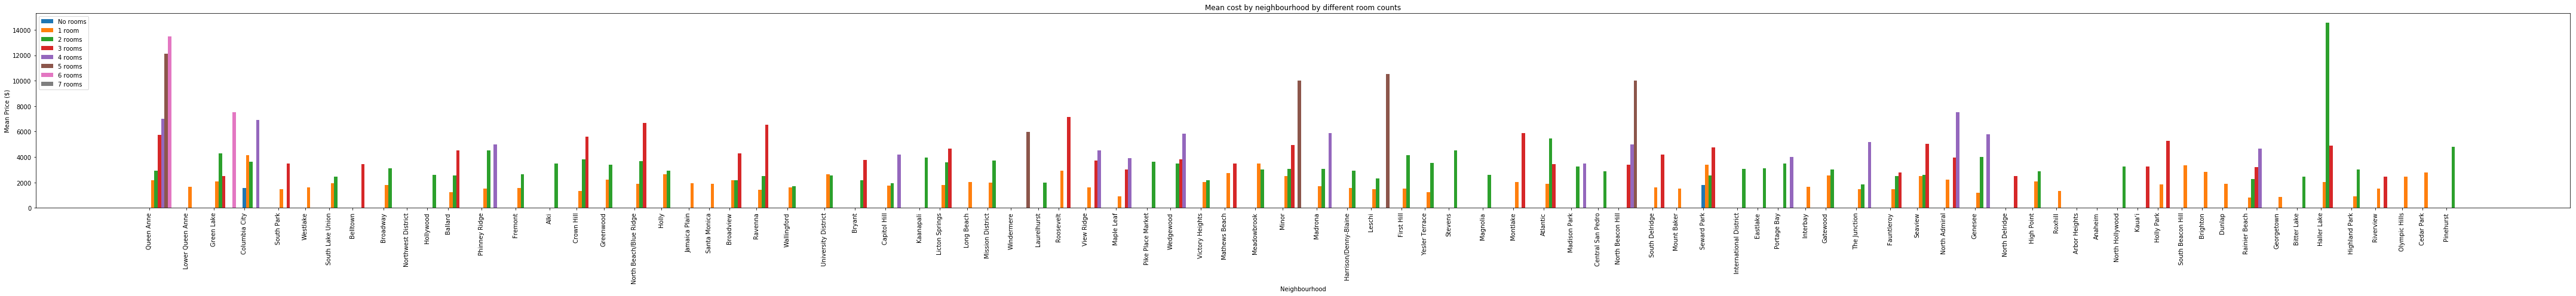

In [66]:
import random, math

frig, ax = plt.subplots(figsize=(60,7))
frig.subplots_adjust(hspace=10)
width = 0.4
padding = 5

by_hood = data.groupby('host_neighbourhood')
hoods = data.host_neighbourhood.dropna().unique()

fewhosts = data.host_neighbourhood.dropna().unique()[:]
subdata = data[data['host_neighbourhood'].isin(fewhosts)]

roomconfigs = {}
for i in subdata.host_neighbourhood.dropna().unique():
    roomconfigs[i] = len(subdata[subdata['host_neighbourhood'] == i].bedrooms.dropna().unique())
    
starts = {}
pads = {}
cur = 0
p = 0
for i in subdata.host_neighbourhood.dropna().unique():
    starts[i] = cur * width
    pads[i] = p
    p = p + padding * width
    cur = cur + roomconfigs[i]
    
rooms = subdata.sort_values('bedrooms').bedrooms.dropna().unique()
r = 0
for i in rooms:
    by_hood = subdata[subdata['bedrooms'] == i].groupby('host_neighbourhood')
    hoods = subdata[subdata['bedrooms'] == i].host_neighbourhood.dropna().unique()
    prices = by_hood.monthly_price_airbnb.mean()
    pos = [r*width + starts[x] + pads[x] for x in hoods]
    r = r + 1
        
    plt.bar(pos, prices, width)

ax.set_xticks([starts[x] + pads[x] for x in subdata.host_neighbourhood.dropna().unique()])
ax.set_xticklabels(subdata.host_neighbourhood.dropna().unique())
plt.xticks(rotation='vertical')
plt.legend(["No rooms", "1 room"] + [str(x) + " rooms" for x in range(2,len(rooms))], loc='upper left')
plt.title("Mean cost by neighbourhood by different room counts")
plt.xlabel("Neighbourhood")
plt.ylabel("Mean Price ($)")
plt.tight_layout()

### Fit Data

In [74]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import linear_model

important_features = ['daily_price_airbnb', 'bedrooms', 'bathrooms', 'zipcode', 'bed_type', 'beds', 'number_of_reviews', 'longitude', 'latitude', 'accommodates', 'security_deposit', 'cleaning_fee', 'guests_included','availability_365','reviews_per_month','host_listings_count']
for i in transit_types:
    important_features.append(i)

features = data[important_features]
print(important_features)
features.zipcode = features.zipcode.astype('float64')
features.bedrooms = features.bedrooms.astype('float64')
norm_features = (features - features.mean())/features.std()

# tested with ratios in the range(0.25, 0.1, 0.35) 
X_train, X_test, y_train, y_test = train_test_split(norm_features, data['housing_price_avg'], test_size=0.3, random_state=0)

['daily_price_airbnb', 'bedrooms', 'bathrooms', 'zipcode', 'bed_type', 'beds', 'number_of_reviews', 'longitude', 'latitude', 'accommodates', 'security_deposit', 'cleaning_fee', 'guests_included', 'availability_365', 'reviews_per_month', 'host_listings_count', 'bus', 'parking', 'taxi', 'walk', 'bike', 'no_transit']


/usr/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


We normalize the __price_x__ attribute because it has a range vastly greater thatn the other 2 attributes __bedrooms__ and __bathrooms__

In [75]:
#from sklearn import preprocessing
#X_train_scaled = preprocessing.scale(X_train)
#X_test_scaled = preprocessing.scale(X_test)

### Apply KNN

k: 1 -> Score: 0.4353292833599499
k: 2 -> Score: 0.43440211585146427
k: 3 -> Score: 0.4318788658529107
k: 4 -> Score: 0.42894655709027363
k: 5 -> Score: 0.426128615813265
k: 6 -> Score: 0.42256399631798536
k: 7 -> Score: 0.41890077158352756
k: 8 -> Score: 0.41437228250345337
k: 9 -> Score: 0.41097380587570964


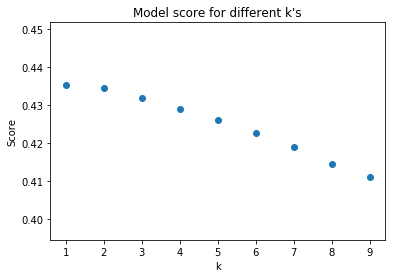

In [76]:
from sklearn.neighbors import KNeighborsRegressor

# score against actual housing_price
real_y_idx = y_test.index.values
real_y = data.housing_price.loc[real_y_idx]

# Test multiple k's
ns = []
x = range(1,10)
for i in x:
    reg = KNeighborsRegressor(n_neighbors=i)
    reg.fit(X_train, y_train)
    ns.append(reg.score(X_test,real_y))
    print('k: {} -> Score: {}'.format(i,ns[i-1]))

fig, arr = plt.subplots()
arr.scatter(x,ns)
plt.title('Model score for different k\'s')
plt.xlabel("k")
plt.ylabel("Score")

# predict a random input
mx = max(ns)
#reg = KNeighborsRegressor(n_neighbors=ns.index(mx)+1)
#reg.fit(X_train_scaled,y_train)
#output = reg.predict(preprocessing.scale([[80,3,1.5,98103]]))
#print('\nAirBnB listing with ${}, {} Bedrooms, {} Bathrooms, zipcode {} predicted a house price of {}'.format(80,3,1.5,98103,output[0]))

### Apply Ridge Regression

0.599931234603
0.599932215852
0.599933195148
0.599934172491
0.599935147884
0.599936121327
0.599937092822
0.599938062371
0.599939029975
0.599939995635
0.599940959352
0.599941921129
0.599942880966
0.599943838865
0.599944794827
0.599945748854
0.599946700946
0.599947651106
0.599948599335
0.599949545634
0.599950490004
0.599951432448
0.599952372965
0.599953311559
0.599954248229
0.599955182978
0.599956115806
0.599957046715
0.599957975708
0.599958902783
0.599959827945
0.599960751192
0.599961672528
0.599962591953
0.599963509469
0.599964425077
0.599965338778
0.599966250574
0.599967160466
0.599968068455
0.599968974543
0.599969878732
0.599970781022
0.599971681414
0.599972579911
0.599973476514
0.599974371223
0.599975264041
0.599976154968
0.599977044006
0.599977931156
0.59997881642
0.599979699799
0.599980581294
0.599981460907
0.599982338638
0.59998321449
0.599984088464
0.59998496056
0.59998583078
0.599986699126
0.599987565599
0.5999884302
0.599989292931
0.599990153792
0.599991012785
0.599991869912
0

Text(0,0.5,'Score')

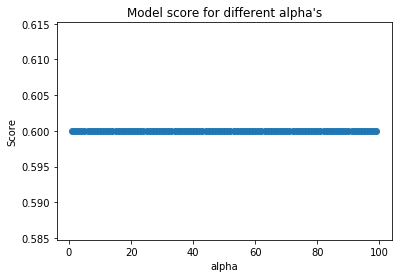

In [77]:
from sklearn import linear_model

ns = []
x = range(1,100)
for i in x:
    reg =linear_model.Ridge(alpha = i)
    reg.fit(X_train,y_train)
    ns.append(reg.score(X_test,y_test))
    print(ns[-1])
  
fig, arr = plt.subplots()
arr.scatter(x,ns)
plt.title('Model score for different alpha\'s')
plt.xlabel("alpha")
plt.ylabel("Score")


### Apply Lasso Regression

0.600202884607


Text(0,0.5,'Score')

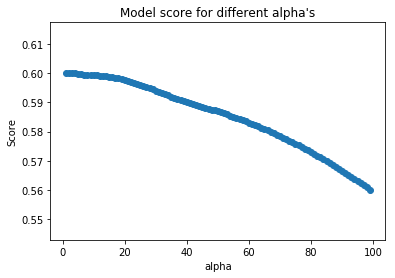

In [78]:
from sklearn import linear_model

ns = []
x = range(1,100)
for i in x:
    reg =linear_model.Lasso(alpha = i, normalize=True)
    reg.fit(X_train,y_train)
    ns.append(reg.score(X_test,y_test))
print(max(ns))
    
fig, arr = plt.subplots()
arr.scatter(x,ns)
plt.title('Model score for different alpha\'s')
plt.xlabel("alpha")
plt.ylabel("Score")

In [ ]:
# TODOS: apply and plot the score of other models, don't hate linear regression, give it a chance
#        comment on the data, add some latin if you so desire
#        if you plot -> matplotlib subplots